## Import Libraries and Understand the Data

In [62]:
%%capture
%pip install scikit-learn pandas numpy matplotlib tensorflow

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (SimpleRNN, LSTM, Dense, Layer, Dropout, Multiply,
                                     Lambda, Input, Add, LayerNormalization, Concatenate,
                                     Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Preprocessing

## Load and Clean FRED-MD and Wheat Futures Data

### Load the FRED-MD Macroeconomic Dataset

In [64]:
macro_df = pd.read_csv("data/FRED_MD.csv")
macro_df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9998,23.6312,22.5507,32.1377,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,17819.01912,22.4306,23.9501,22.7461,32.3734,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,17967.91336,22.7538,24.0951,22.8577,32.3734,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,17978.97983,23.2384,24.4431,23.1926,32.8841,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


### Clean FRED-MD Dates and Remove Metadata Rows

In [65]:
macro_df["sasdate"] = pd.to_datetime(macro_df["sasdate"], errors="coerce")
macro_df = macro_df.dropna(subset=["sasdate"])
macro_df = macro_df.set_index("sasdate").sort_index()
macro_df.head()

/var/folders/0l/1ppqpvg53sxd4dc_2y_x3h300000gn/T/ipykernel_53035/2543654388.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  macro_df["sasdate"] = pd.to_datetime(macro_df["sasdate"], errors="coerce")


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9998,23.6312,22.5507,32.1377,19.7514,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,278713.9773,17819.01912,22.4306,23.9501,22.7461,32.3734,19.8551,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,277775.2539,17967.91336,22.7538,24.0951,22.8577,32.3734,20.2439,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,283362.7075,17978.97983,23.2384,24.4431,23.1926,32.8841,20.3735,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,285307.2201,18119.82573,23.5885,24.6460,23.4159,33.0413,20.7882,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


### Load the Wheat Futures Dataset

In [66]:
wheat_train = pd.read_csv("data/wheat_prices_train.csv")
wheat_val = pd.read_csv("data/wheat_prices_val.csv")
wheat_test = pd.read_csv("data/wheat_prices_test.csv")
wheat_train.shape, wheat_val.shape, wheat_test.shape

((4066, 7), (2555, 7), (255, 7))

### Calculate Log Returns

In [67]:
for df in [wheat_train, wheat_val, wheat_test]:
    df["Price"] = (
        df["Price"]
        .astype(str)
        .str.replace(",", "")
    )
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
    df["LogReturn"] = np.log(df["Price"]).diff()

wheat_train["LogReturn"] = np.log(wheat_train["Price"]).diff()
wheat_val["LogReturn"] = np.log(wheat_val["Price"]).diff()
wheat_test["LogReturn"] = np.log(wheat_test["Price"]).diff()

wheat_train = wheat_train.set_index("Date").sort_index()
wheat_val = wheat_val.set_index("Date").sort_index()
wheat_test = wheat_test.set_index("Date").sort_index()

wheat_train.head()

,Price,Open,High,Low,Vol.,Change %,LogReturn
Date,,,,,,,
01/01/2000,256.25,249.00,269.00,241.00,345.62K,3.12%,0.034743
01/01/2001,273.00,278.50,294.50,268.00,410.55K,-2.33%,-0.011834
01/01/2002,286.00,290.50,313.25,283.50,438.19K,-1.04%,-0.020762
01/01/2003,320.50,325.75,339.00,307.50,296.18K,-1.38%,-0.025415
01/01/2004,389.00,377.50,407.00,373.00,469.00K,3.18%,-0.042158


## Resampling

Macroeconomic data does not lose relevance instantly after release.  
Instead, its influence **decays gradually over time**.

So, we use **decay-weighted resampling**, where macroeconomic signals fade smoothly rather than changing abruptly.



### Resample Macro Data to Daily Frequency

In [68]:
macro_daily = macro_df.resample("D").ffill()
macro_daily.shape

(24412, 126)

### Detect Release Events Per Column

In [69]:
release_mask = macro_daily.ne(macro_daily.shift(1))
release_mask.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1959-01-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1959-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1959-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1959-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


### Compute Days Since Last Release

In [70]:
days_since_release = release_mask.cumsum()
days_since_release = days_since_release.apply(lambda x: x.groupby(x).cumcount())
days_since_release.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1959-01-02,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
1959-01-03,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,0
1959-01-04,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,0,3,3,3,0
1959-01-05,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,4,0


### Apply Decay-Weighted Forward Fill

In [71]:
decay_rate = 0.02
decay_factors = np.exp(-decay_rate * days_since_release)
macro_decay = macro_daily * decay_factors
macro_decay.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560000,2426.000000,15.188000,276676.815400,17689.239680,21.999800,23.631200,22.550700,32.137700,19.751400,...,18.294000,10.152000,2.130000,2.450000,2.040000,NaN,6476.000000,12298.000000,84.204300,NaN
1959-01-02,2532.402084,2377.961981,14.887257,271198.247390,17338.969266,21.564175,23.163271,22.104166,31.501331,19.360296,...,17.931755,9.950977,2.087823,2.401487,1.999605,NaN,6347.766608,12054.483284,82.536943,NaN
1959-01-03,2482.257163,2330.875179,14.592470,265828.162295,16995.634671,21.137176,22.704607,21.666474,30.877563,18.976937,...,17.576682,9.753934,2.046482,2.353934,1.960010,NaN,6222.072408,11815.788523,80.902602,NaN
1959-01-04,2433.105178,2284.720758,14.303520,260564.412009,16659.098557,20.718631,22.255026,21.237449,30.266146,18.601168,...,17.228640,9.560794,2.005958,2.307323,1.921200,NaN,6098.867119,11581.820234,79.300623,NaN
1959-01-05,2384.926468,2239.480256,14.020291,255404.890962,16329.226304,20.308375,21.814347,20.816920,29.666836,18.232840,...,16.887490,9.371477,1.966238,2.261635,1.883157,NaN,5978.101459,11352.484828,77.730366,NaN


In [72]:
macro_df = macro_decay.reset_index()
macro_df = macro_df.rename(columns={"sasdate": "Date"})
macro_df["Date"] = macro_df["Date"].dt.strftime("%m/%d/%Y")
macro_df = macro_df.set_index("Date").sort_index()
macro_df.head()

/var/folders/0l/1ppqpvg53sxd4dc_2y_x3h300000gn/T/ipykernel_53035/599888185.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  macro_df = macro_decay.reset_index()


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
Date,,,,,,,,,,,,,,,,,,,,,
01/01/1959,2583.560,2426.0,15.188,276676.8154,17689.23968,21.9998,23.6312,22.5507,32.1377,19.7514,...,18.294,10.152,2.13,2.45,2.04000,NaN,6476.0,12298.0,84.2043,NaN
01/01/1960,2695.694,2537.6,15.789,286930.9859,18201.31515,24.2078,25.5738,24.3928,34.4949,22.6026,...,18.410,10.466,2.22,2.57,2.13000,NaN,7362.0,14063.0,75.4515,NaN
01/01/1961,2734.050,2556.6,15.956,265935.1877,18061.47529,22.1613,24.3560,23.3880,33.1591,19.0515,...,18.749,10.676,2.27,2.72,1.16196,NaN,7562.0,15317.0,79.3604,NaN
01/01/1962,2890.321,2700.8,16.845,292962.8571,19123.85583,24.6925,26.4437,25.4533,36.2629,22.9137,...,18.627,10.873,2.36,2.87,2.25000,NaN,6888.0,15451.0,87.4541,NaN
01/01/1963,3025.392,2806.3,17.612,298556.2101,20423.66233,25.9581,28.2124,27.2953,38.2666,24.7540,...,18.886,11.069,2.42,2.94,2.30000,NaN,7553.0,17405.0,91.4475,14.8357


In [73]:
selected_features = [
    "RPI", "W875RX1", "CMRMTSPLx", "IPFPNSS", "USWTRADE", "USTRADE", "BUSLOANS", "CONSPI", "S&P 500", "S&P PE ratio",
    "FEDFUNDS", "TB3MS", "TB6MS", "GS1", "GS5", "GS10", "AAA", "BAA", "TB3SMFFM", "TB6SMFFM", "T1YFFM", "T5YFFM", "T10YFFM",
    "AAAFFM", "BAAFFM", "EXSZUSx", "EXJPUSx", "EXUSUKx", "EXCAUSx", "PPICMM", "UMCSENTx"
]

macro_df = macro_df[selected_features]
macro_df.head()

,RPI,W875RX1,CMRMTSPLx,IPFPNSS,USWTRADE,USTRADE,BUSLOANS,CONSPI,S&P 500,S&P PE ratio,...,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,PPICMM,UMCSENTx
Date,,,,,,,,,,,,,,,,,,,,,
01/01/1959,2583.560,2426.0,276676.8154,23.6312,2568.7,5350.3,35.2130,124.964676,55.62,18.445741,...,1.53,1.54,1.64,2.390000,4.3122,359.841700,2.8065,0.9671,32.500000,NaN
01/01/1960,2695.694,2537.6,286930.9859,25.5738,2657.9,5554.1,39.6291,134.750012,58.03,17.547138,...,0.93,0.73,0.62,1.350000,4.3268,360.360400,2.7998,0.9532,34.200000,NaN
01/01/1961,2734.050,2556.6,265935.1877,24.3560,2659.4,5565.5,42.0358,141.657366,59.72,17.917807,...,2.22,2.39,2.87,3.650000,4.3066,358.937500,2.8064,0.9931,32.300000,NaN
01/01/1962,2890.321,2700.8,292962.8571,26.4437,2685.7,5604.1,43.9853,136.585088,69.07,22.223884,...,1.79,1.93,2.27,2.930000,4.3182,194.738092,2.8110,1.0452,17.805961,NaN
01/01/1963,3025.392,2806.3,298556.2101,28.2124,2735.9,5725.6,47.6623,141.852190,65.06,18.659080,...,0.66,0.91,1.29,1.070509,4.3253,358.500000,2.8048,1.0773,32.400000,NaN


In [74]:
train_merged = wheat_train[["LogReturn"]].join(macro_df, how="inner").dropna()
val_merged = wheat_val[["LogReturn"]].join(macro_df, how="inner").dropna()
test_merged = wheat_test[["LogReturn"]].join(macro_df, how="inner").dropna()

print(f"Train Merged: {train_merged.shape}")
print(f"Val Merged:   {val_merged.shape}")
print(f"Test Merged:  {test_merged.shape}")

Train Merged: (4065, 32)
Val Merged:   (2554, 32)
Test Merged:  (190, 32)


## Data Preparation 

In [75]:
train_merged.info()

<class 'pandas.DataFrame'>
Index: 4065 entries, 01/01/2000 to 12/31/2013
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LogReturn     4065 non-null   float64
 1   RPI           4065 non-null   float64
 2   W875RX1       4065 non-null   float64
 3   CMRMTSPLx     4065 non-null   float64
 4   IPFPNSS       4065 non-null   float64
 5   USWTRADE      4065 non-null   float64
 6   USTRADE       4065 non-null   float64
 7   BUSLOANS      4065 non-null   float64
 8   CONSPI        4065 non-null   float64
 9   S&P 500       4065 non-null   float64
 10  S&P PE ratio  4065 non-null   float64
 11  FEDFUNDS      4065 non-null   float64
 12  TB3MS         4065 non-null   float64
 13  TB6MS         4065 non-null   float64
 14  GS1           4065 non-null   float64
 15  GS5           4065 non-null   float64
 16  GS10          4065 non-null   float64
 17  AAA           4065 non-null   float64
 18  BAA           4065 non-null  

### Standard Scaling

In [76]:
target_col = "LogReturn"
feature_cols = [c for c in train_merged.columns if c != target_col]

X_train = train_merged[feature_cols].values
y_train = train_merged[target_col].values

X_val = val_merged[feature_cols].values
y_val = val_merged[target_col].values

X_test = test_merged[feature_cols].values
y_test = test_merged[target_col].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [77]:
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()
print(f"Target scaled - Train mean: {y_train_scaled.mean():.4f}, std: {y_train_scaled.std():.4f}")

Target scaled - Train mean: 0.0000, std: 1.0000


### Create 30-Day Lookback Sequences

Transform data into sliding window sequences of shape `(samples, 30, features)` for temporal neural networks.

In [78]:
def create_sequences(X_data, y_data, lookback=30):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - lookback):
        X_seq.append(X_data[i:i+lookback])
        y_seq.append(y_data[i+lookback])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 30

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

print(f"Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")

Train: (4035, 30, 31), Val: (2524, 30, 31), Test: (160, 30, 31)


### 5-Fold Time Series Cross-Validation

For hyperparameter tuning and model selection, implement 5-fold CV within the training set while preserving temporal order.

# Recurrent Neural Network (RNN)

In [79]:
X_train_seq.shape, y_train_seq.shape

((4035, 30, 31), (4035,))

## RNN Baseline Model

In [80]:
model = Sequential([
    SimpleRNN(
        units=128,
        activation="tanh",
        return_sequences=False,
        recurrent_dropout=0.2,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

/Users/isha/Desktop/Projects/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures_venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Training


In [81]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)
test_loss = model.evaluate(X_test_seq, y_test_seq)
test_loss

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2175 - val_loss: 1.0715
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0694 - val_loss: 1.0449
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0478 - val_loss: 0.9929
Epoch 4/20
103/127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0066

KeyboardInterrupt: 

### Evaluate RNN

In [ ]:
y_pred_scaled = model.predict(X_test_seq).flatten()

y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")

mse, rmse, mae

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
MSE:  0.000358
RMSE: 0.018908
MAE:  0.015957


(0.000357521679937873, np.float64(0.01890824370315427), 0.01595709682315875)

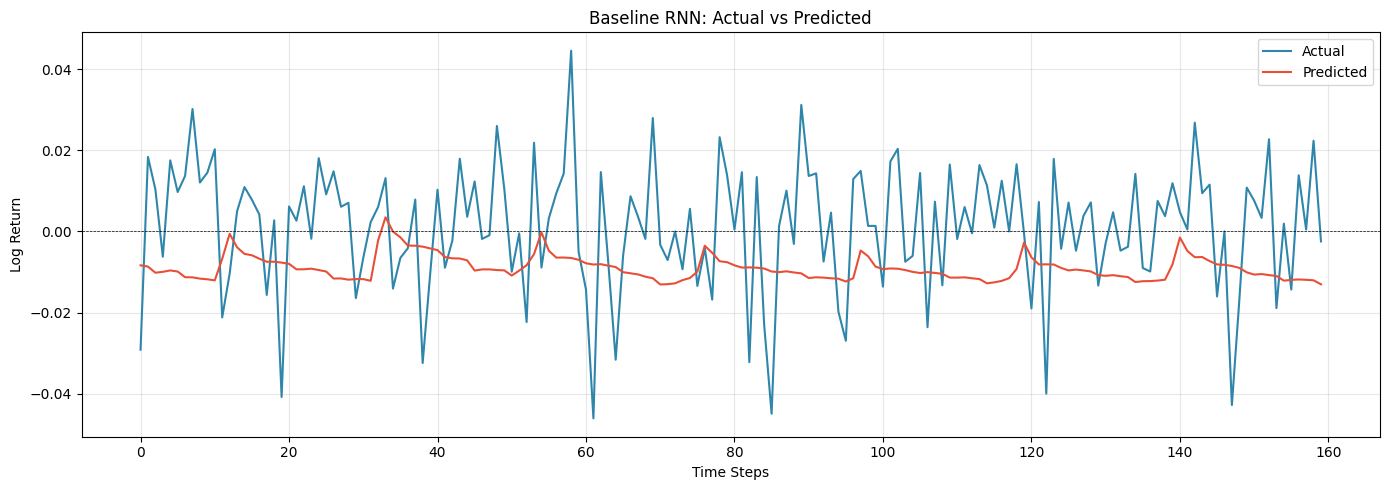

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true)), y_true, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred)), y_pred, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Baseline RNN: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## RNN with Attention Mechanism

Attention allows the model to focus on specific time steps that are most relevant for prediction, rather than relying solely on the final hidden state.

In [ ]:
class AttentionLayer(Layer):
    
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        
        if self.return_attention:
            return attention_weights
        return context_vector
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build RNN with Attention Model

In [ ]:
def build_rnn_attention_model(seq_length, n_features, rnn_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = SimpleRNN(
        units=rnn_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate
    )(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(rnn_out)
    x = Dropout(dropout_rate)(context_vector)  
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


rnn_attention_model = build_rnn_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=128,
    dropout_rate=0.2
)

rnn_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse'
)

rnn_attention_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 128)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,249 (145.50 KB)

 Trainable params: 37,249 (145.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train RNN with Attention

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_attention = rnn_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.0756 - val_loss: 1.1775 - learning_rate: 5.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0456 - val_loss: 1.1330 - learning_rate: 5.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0319 - val_loss: 1.0976 - learning_rate: 5.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0322 - val_loss: 1.0948 - learning_rate: 5.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0280 - val_loss: 0.9878 - learning_rate: 5.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0211 - val_loss: 0.8893 - learning_rate: 5.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0123 - val_loss: 0.9299 - learning_rate: 5.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0243 - val_loss: 0.9365 - learning_rate: 5.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0113 - val_loss: 

### Evaluate RNN with Attention

In [ ]:
y_pred_attention_scaled = rnn_attention_model.predict(X_test_seq).flatten()

y_pred_attention = target_scaler.inverse_transform(y_pred_attention_scaled.reshape(-1, 1)).flatten()
y_true_attention = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_att = mean_squared_error(y_true_attention, y_pred_attention)
rmse_att = np.sqrt(mse_att)
mae_att = mean_absolute_error(y_true_attention, y_pred_attention)

print(f"MSE:  {mse_att:.6f}")
print(f"RMSE: {rmse_att:.6f}")
print(f"MAE:  {mae_att:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
MSE:  0.000483
RMSE: 0.021967
MAE:  0.018907


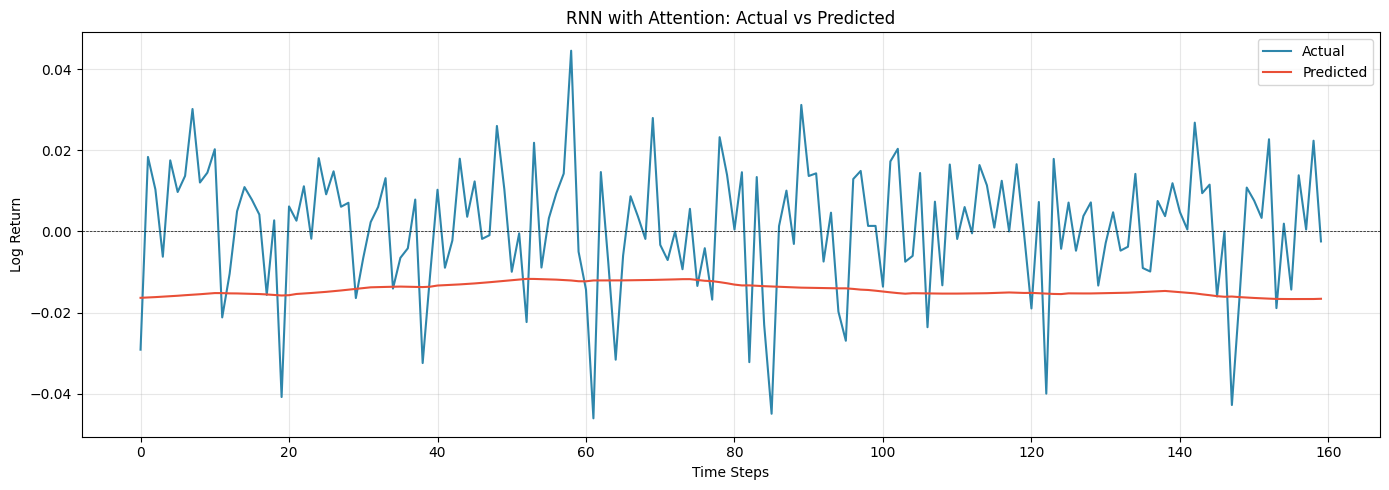

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_attention)), y_true_attention, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_attention)), y_pred_attention, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'RNN with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## RNN with Attention and Skip Connections

In [ ]:
class AttentionLayer(Layer):
    
    def __init__(self, return_attention=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        
        if self.return_attention:
            return attention_weights
        return context_vector
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Model with Skip Connections

In [ ]:
def build_rnn_attention_skip_model(seq_length, n_features, rnn_units=64, dropout_rate=0.3):
    
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = SimpleRNN(
        units=rnn_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    )(inputs)
    
    context_vector = AttentionLayer(return_attention=False)(rnn_out)
    last_hidden = rnn_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(rnn_units, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])
    
    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)
    
    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


rnn_attention_skip_model = build_rnn_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=64, 
    dropout_rate=0.3
)

rnn_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4), # Reduced from 5e-4
    loss='mse'
)

rnn_attention_skip_model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 30, 64)    │      6,144 │ input_layer_2[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_1   │ (None, 64)        │      4,224 │ simple_rnn_2[0][… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64)        │          0 │ simple_rnn_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ attention_layer_… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 64)        │          0 │ get_item[0][0],   │
│ (Multiply)          │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64)        │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,865 (81.50 KB)

 Trainable params: 20,865 (81.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_skip = rnn_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.2843 - val_loss: 1.0916 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8654 - val_loss: 1.1189 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6941 - val_loss: 1.1597 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5503 - val_loss: 1.1448 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4400 - val_loss: 1.1397 - learning_rate: 1.0000e-04
Epoch 6/50
123/127 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2505
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3182 - val_loss: 1.1321 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2473 - val_loss: 1.1123 - learning_rate: 5.0000e-05
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2494 - v

### Evaluate Model

In [ ]:
y_pred_skip_scaled = rnn_attention_skip_model.predict(X_test_seq).flatten()

y_pred_skip = target_scaler.inverse_transform(y_pred_skip_scaled.reshape(-1, 1)).flatten()
y_true_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_skip = mean_squared_error(y_true_skip, y_pred_skip)
rmse_skip = np.sqrt(mse_skip)
mae_skip = mean_absolute_error(y_true_skip, y_pred_skip)

print(f"MSE:  {mse_skip:.6f}")
print(f"RMSE: {rmse_skip:.6f}")
print(f"MAE:  {mae_skip:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
MSE:  0.000287
RMSE: 0.016931
MAE:  0.013676


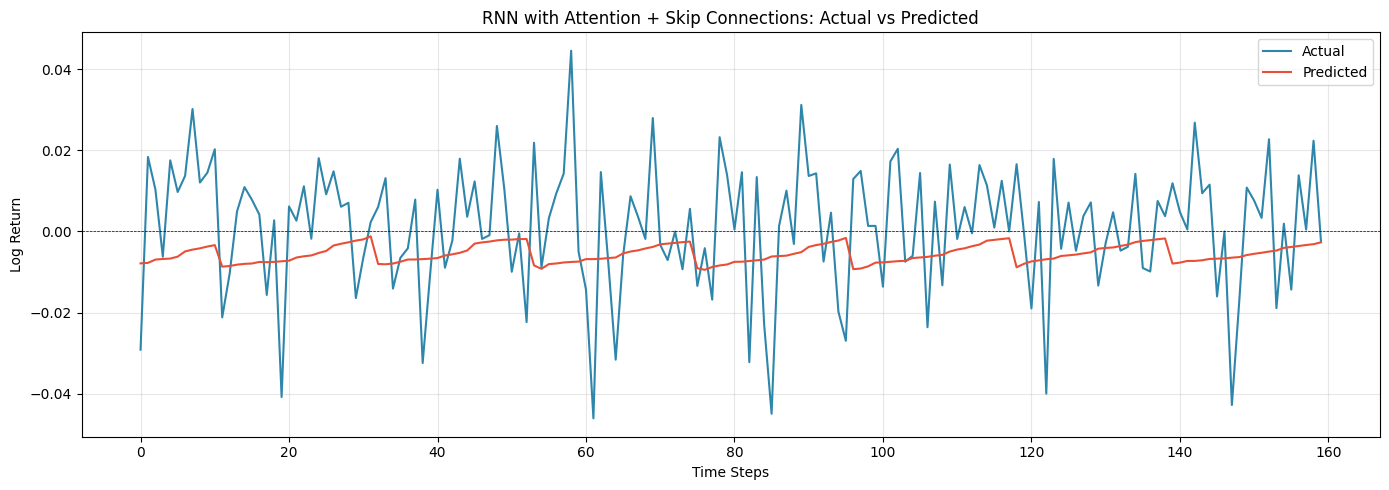

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_skip)), y_true_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_skip)), y_pred_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'RNN with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Bidirectional Recurrent Neural Network (BiRNN)

## Bidirectional RNN Baseline Model

In [ ]:
bidir_model = Sequential([
    Bidirectional(
        SimpleRNN(
            units=128,
            activation="tanh",
            return_sequences=False,
            recurrent_dropout=0.2
        ),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

bidir_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

/Users/isha/Desktop/Projects/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures_venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Training

In [ ]:
history_bidir = bidir_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)
test_loss_bidir = bidir_model.evaluate(X_test_seq, y_test_seq)
test_loss_bidir

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.2288 - val_loss: 1.4323
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.1062 - val_loss: 1.3076
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0717 - val_loss: 1.3830
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0435 - val_loss: 1.1019
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0266 - val_loss: 1.0206
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0250 - val_loss: 1.0217
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0164 - val_loss: 1.3547
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.9966 - val_loss: 1.0545
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0101 - val_loss: 1.0917
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0094 - val_loss: 0.9356
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9897 - val_loss: 0.9293
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 

0.841143012046814

### Evaluate Bidirectional RNN

In [ ]:
y_pred_bidir_scaled = bidir_model.predict(X_test_seq).flatten()

y_pred_bidir = target_scaler.inverse_transform(y_pred_bidir_scaled.reshape(-1, 1)).flatten()
y_true_bidir = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir = mean_squared_error(y_true_bidir, y_pred_bidir)
rmse_bidir = np.sqrt(mse_bidir)
mae_bidir = mean_absolute_error(y_true_bidir, y_pred_bidir)

print(f"MSE:  {mse_bidir:.6f}")
print(f"RMSE: {rmse_bidir:.6f}")
print(f"MAE:  {mae_bidir:.6f}")

mse_bidir, rmse_bidir, mae_bidir

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
MSE:  0.000424
RMSE: 0.020591
MAE:  0.017440


(0.00042398464005172654,
 np.float64(0.020590887306080972),
 0.017440438633110483)

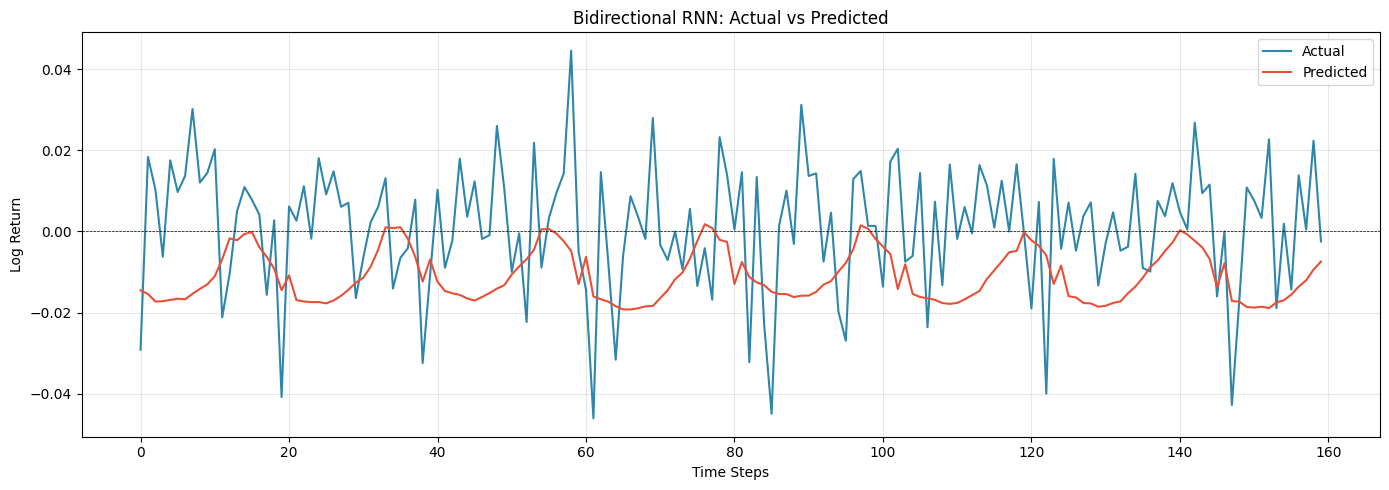

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir)), y_true_bidir, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir)), y_pred_bidir, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Bidirectional RNN with Attention Mechanism

Wrapping the RNN in a Bidirectional layer lets the model capture both past and future context at every time step, while attention selectively weights the most informative positions.

In [ ]:
class BiDirAttentionLayer(Layer):

    def __init__(self, return_attention=False, **kwargs):
        super(BiDirAttentionLayer, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BiDirAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        if self.return_attention:
            return attention_weights
        return context_vector

    def get_config(self):
        config = super(BiDirAttentionLayer, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Bidirectional RNN with Attention Model

In [ ]:
def build_bidir_rnn_attention_model(seq_length, n_features, rnn_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    rnn_out = Bidirectional(
        SimpleRNN(
            units=rnn_units,
            activation='tanh',
            return_sequences=True,
            recurrent_dropout=dropout_rate
        )
    )(inputs)

    context_vector = BiDirAttentionLayer(return_attention=False)(rnn_out)
    x = Dropout(dropout_rate)(context_vector)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


bidir_rnn_attention_model = build_bidir_rnn_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=128,
    dropout_rate=0.2
)

bidir_rnn_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss='mse'
)

bidir_rnn_attention_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 256)        │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_dir_attention_layer          │ (None, 256)            │        66,048 │
│ (BiDirAttentionLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,265 (419.00 KB)

 Trainable params: 107,265 (419.00 KB)

 Non-trainable params: 0 (0.00 B)

### Train Bidirectional RNN with Attention

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_bidir_attention = bidir_rnn_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1.1029 - val_loss: 1.2175 - learning_rate: 5.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.0494 - val_loss: 1.2183 - learning_rate: 5.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.0484 - val_loss: 1.0701 - learning_rate: 5.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.0401 - val_loss: 1.4317 - learning_rate: 5.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.0189 - val_loss: 1.0850 - learning_rate: 5.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0238 - val_loss: 1.1192 - learning_rate: 5.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.0240 - val_loss: 1.0708 - learning_rate: 5.0000e-04
Epoch 8/50
125/127 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9758
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1

### Evaluate Bidirectional RNN with Attention

In [ ]:
y_pred_bidir_att_scaled = bidir_rnn_attention_model.predict(X_test_seq).flatten()

y_pred_bidir_att = target_scaler.inverse_transform(y_pred_bidir_att_scaled.reshape(-1, 1)).flatten()
y_true_bidir_att = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir_att = mean_squared_error(y_true_bidir_att, y_pred_bidir_att)
rmse_bidir_att = np.sqrt(mse_bidir_att)
mae_bidir_att = mean_absolute_error(y_true_bidir_att, y_pred_bidir_att)

print(f"MSE:  {mse_bidir_att:.6f}")
print(f"RMSE: {rmse_bidir_att:.6f}")
print(f"MAE:  {mae_bidir_att:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
MSE:  0.000284
RMSE: 0.016856
MAE:  0.013604


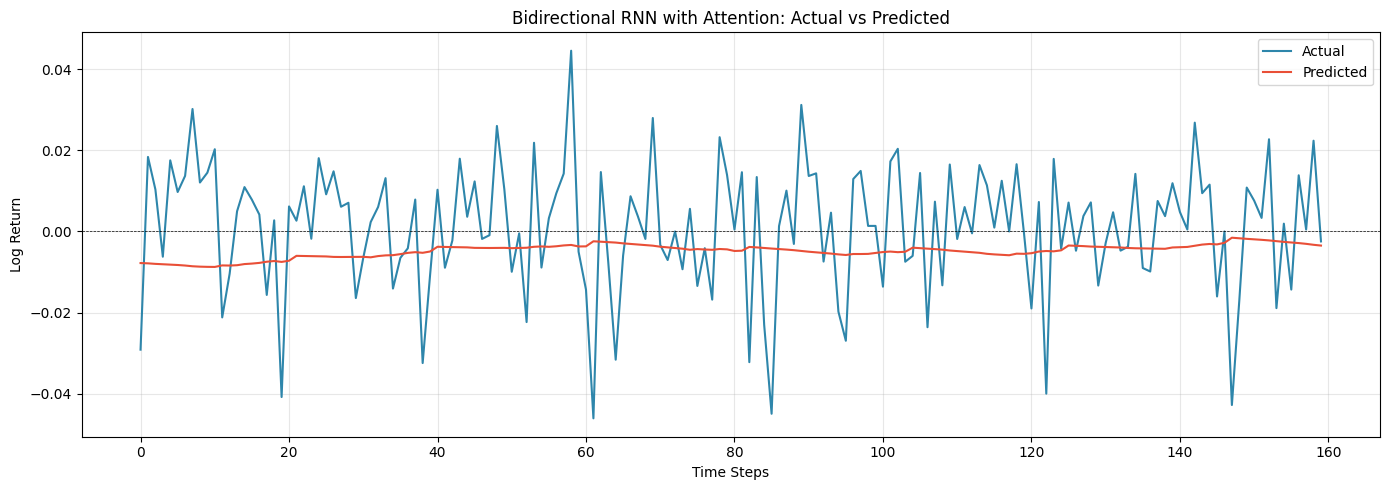

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir_att)), y_true_bidir_att, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir_att)), y_pred_bidir_att, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Bidirectional RNN with Attention and Skip Connections

In [ ]:
class BiDirAttentionLayerSkip(Layer):

    def __init__(self, return_attention=False, **kwargs):
        super(BiDirAttentionLayerSkip, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BiDirAttentionLayerSkip, self).build(input_shape)

    def call(self, inputs):
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.u, axes=1), axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)

        if self.return_attention:
            return attention_weights
        return context_vector

    def get_config(self):
        config = super(BiDirAttentionLayerSkip, self).get_config()
        config.update({'return_attention': self.return_attention})
        return config

### Build Model with Skip Connections

In [ ]:
def build_bidir_rnn_attention_skip_model(seq_length, n_features, rnn_units=64, dropout_rate=0.3):

    inputs = Input(shape=(seq_length, n_features))
    rnn_out = Bidirectional(
        SimpleRNN(
            units=rnn_units,
            return_sequences=True,
            recurrent_dropout=dropout_rate,
            kernel_regularizer=l2(1e-4),
            recurrent_regularizer=l2(1e-4)
        )
    )(inputs)

    context_vector = BiDirAttentionLayerSkip(return_attention=False)(rnn_out)
    last_hidden = rnn_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(rnn_units * 2, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])

    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)

    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


bidir_rnn_attention_skip_model = build_bidir_rnn_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    rnn_units=64,
    dropout_rate=0.3
)

bidir_rnn_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mse'
)

bidir_rnn_attention_skip_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 30, 128)   │     12,288 │ input_layer_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_dir_attention_l… │ (None, 128)       │     16,640 │ bidirectional_2[… │
│ (BiDirAttentionLay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128)       │          0 │ bidirectional_2[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ bi_dir_attention… │
│ (Concatenate)       │                   │            │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     32,896 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 128)       │          0 │ bi_dir_attention… │
│ (Multiply)          │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 128)       │          0 │ get_item_1[0][0], │
│ (Multiply)          │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128)       │          0 │ multiply_2[0][0], │
│                     │                   │            │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      4,128 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,241 (258.75 KB)

 Trainable params: 66,241 (258.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_bidir_skip = bidir_rnn_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.7898 - val_loss: 0.9146 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.1054 - val_loss: 0.9208 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.6342 - val_loss: 0.8957 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4332 - val_loss: 0.8951 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3340 - val_loss: 0.8805 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.2033 - val_loss: 0.8930 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1566 - val_loss: 0.8791 - learning_rate: 1.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.1314 - val_loss: 0.8656 - learning_rate: 1.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.0968 - val_loss: 

### Evaluate Model

In [ ]:
y_pred_bidir_skip_scaled = bidir_rnn_attention_skip_model.predict(X_test_seq).flatten()

y_pred_bidir_skip = target_scaler.inverse_transform(y_pred_bidir_skip_scaled.reshape(-1, 1)).flatten()
y_true_bidir_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_bidir_skip = mean_squared_error(y_true_bidir_skip, y_pred_bidir_skip)
rmse_bidir_skip = np.sqrt(mse_bidir_skip)
mae_bidir_skip = mean_absolute_error(y_true_bidir_skip, y_pred_bidir_skip)

print(f"MSE:  {mse_bidir_skip:.6f}")
print(f"RMSE: {rmse_bidir_skip:.6f}")
print(f"MAE:  {mae_bidir_skip:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
MSE:  0.000287
RMSE: 0.016938
MAE:  0.012640


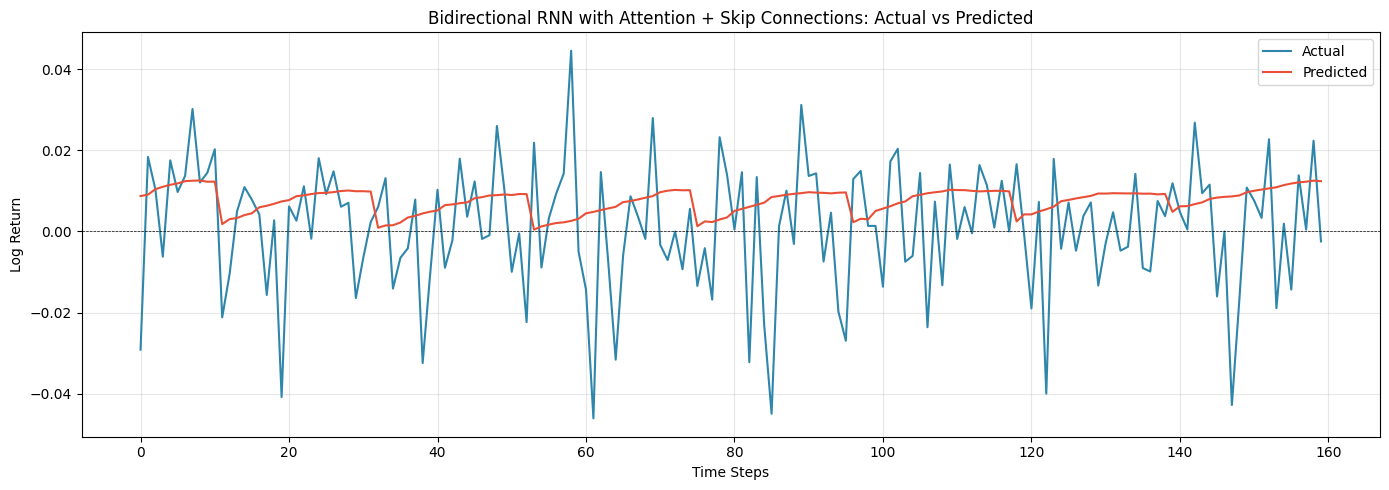

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(range(len(y_true_bidir_skip)), y_true_bidir_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_bidir_skip)), y_pred_bidir_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'Bidirectional RNN with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Long Short-Term Memory (LSTM)

### LSTM Baseline Model

In [ ]:
lstm_model = Sequential([
    LSTM(
        units=128,
        activation="tanh",
        return_sequences=False,
        recurrent_dropout=0.2,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

lstm_model.summary()

/Users/isha/Desktop/Projects/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures/DeepTemporalModelsWithAttentionAndSkipConnectionsForWheatFutures_venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,049 (320.50 KB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [ ]:
history_lstm = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 1.0277 - val_loss: 0.8929
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.0202 - val_loss: 0.8326
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 1.0092 - val_loss: 0.8423
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.0003 - val_loss: 0.8082
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.0023 - val_loss: 0.8743
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 1.0005 - val_loss: 0.8414
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.9979 - val_loss: 0.8574
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.9937 - val_loss: 0.8398
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.9924 - val_loss: 0.8529
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.9885 - val_loss: 0.8937
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.9872 - val_loss: 0.8768
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 

### Evaluate LSTM

In [ ]:
y_pred_lstm_scaled = lstm_model.predict(X_test_seq).flatten()

y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()
y_true_lstm = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)

print(f"MSE:  {mse_lstm:.6f}")
print(f"RMSE: {rmse_lstm:.6f}")
print(f"MAE:  {mae_lstm:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
MSE:  0.000301
RMSE: 0.017348
MAE:  0.013072


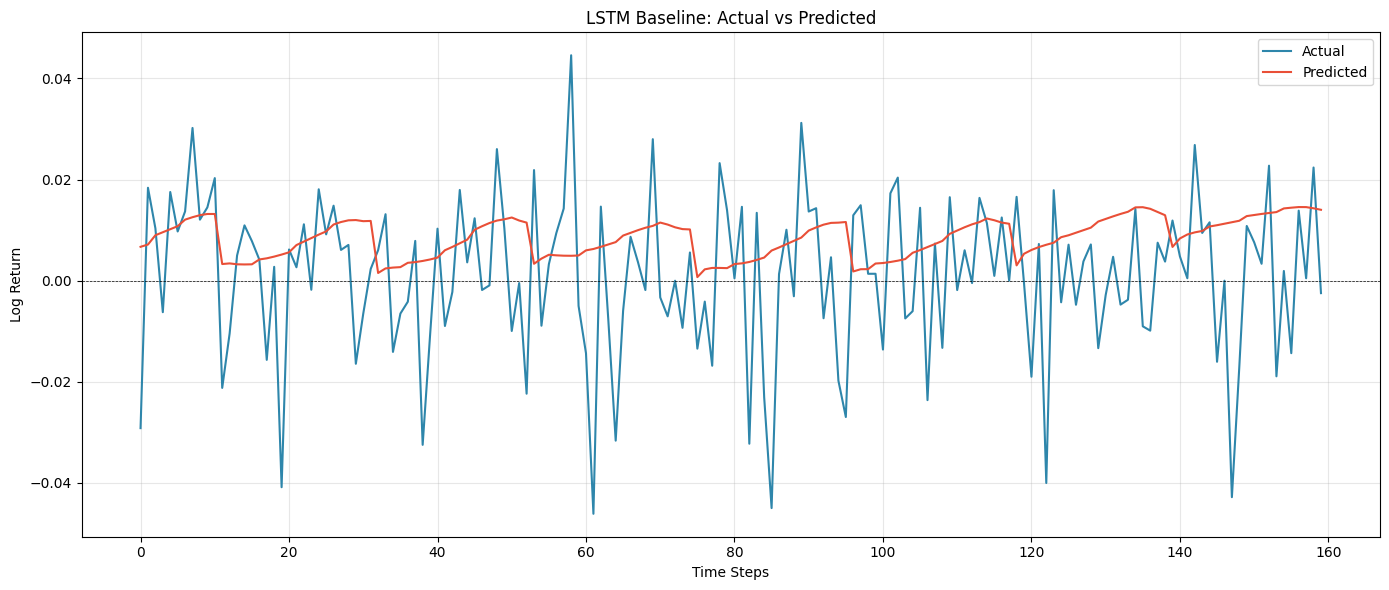

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_lstm)), y_true_lstm, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'LSTM Baseline: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### LSTM with Attention Mechanism

In [ ]:
def build_lstm_attention_model(seq_length, n_features, lstm_units=128, dropout_rate=0.2):
    inputs = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(
        units=lstm_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate
    )(inputs)

    context_vector = AttentionLayer(return_attention=False)(lstm_out)
    x = Dropout(dropout_rate)(context_vector)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Build LSTM with Attention Model

In [ ]:
lstm_attention_model = build_lstm_attention_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2]
)

lstm_attention_model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="mse"
)

lstm_attention_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        81,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_2               │ (None, 128)            │        16,640 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,689 (385.50 KB)

 Trainable params: 98,689 (385.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_lstm_att = lstm_attention_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 1.0220 - val_loss: 1.0180 - learning_rate: 5.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.0059 - val_loss: 1.0580 - learning_rate: 5.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 1.0167 - val_loss: 0.9325 - learning_rate: 5.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 1.0100 - val_loss: 0.9285 - learning_rate: 5.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.0046 - val_loss: 0.8935 - learning_rate: 5.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 1.0028 - val_loss: 0.8832 - learning_rate: 5.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.9999 - val_loss: 0.8185 - learning_rate: 5.0000e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.0006 - val_loss: 0.8345 - learning_rate: 5.0000e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 1.0001 - val_loss: 

### Evaluate Model

In [ ]:
y_pred_lstm_att_scaled = lstm_attention_model.predict(X_test_seq).flatten()

y_pred_lstm_att = target_scaler.inverse_transform(y_pred_lstm_att_scaled.reshape(-1, 1)).flatten()
y_true_lstm_att = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_lstm_att = mean_squared_error(y_true_lstm_att, y_pred_lstm_att)
rmse_lstm_att = np.sqrt(mse_lstm_att)
mae_lstm_att = mean_absolute_error(y_true_lstm_att, y_pred_lstm_att)

print(f"MSE:  {mse_lstm_att:.6f}")
print(f"RMSE: {rmse_lstm_att:.6f}")
print(f"MAE:  {mae_lstm_att:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
MSE:  0.000268
RMSE: 0.016367
MAE:  0.013082


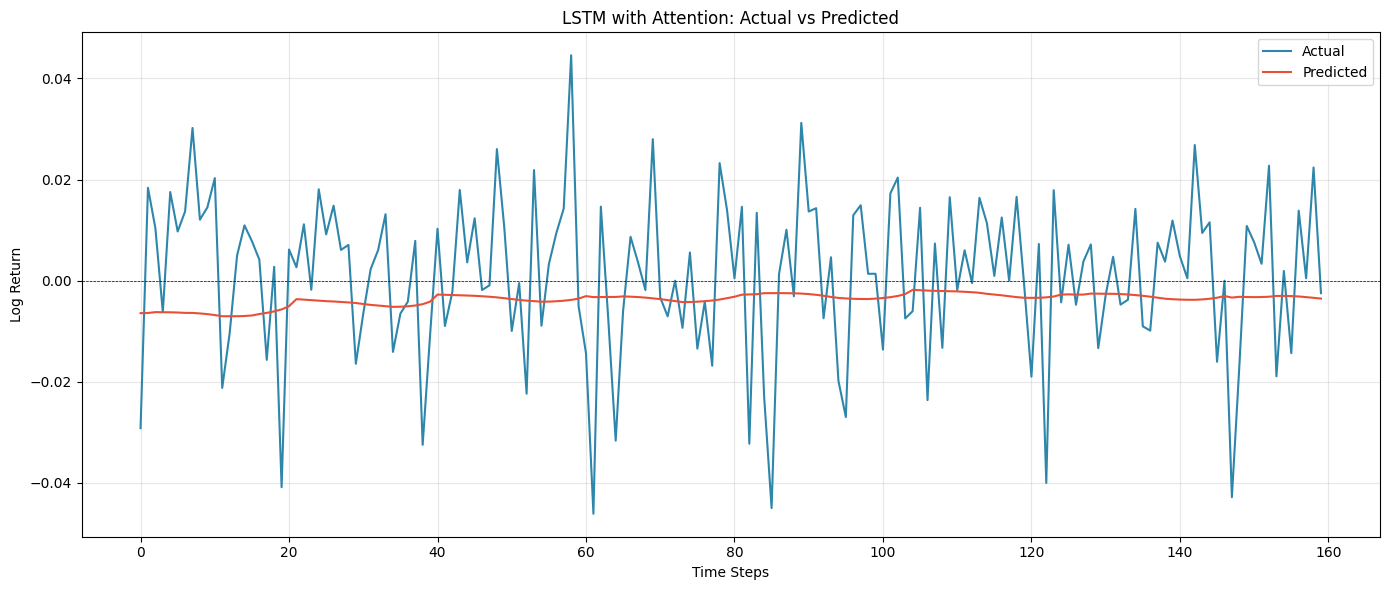

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_lstm_att)), y_true_lstm_att, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_lstm_att)), y_pred_lstm_att, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'LSTM with Attention: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### LSTM with Attention + Skip Connections

In [ ]:
def build_lstm_attention_skip_model(seq_length, n_features, lstm_units=64, dropout_rate=0.3):
    inputs = Input(shape=(seq_length, n_features))
    lstm_out = LSTM(
        units=lstm_units,
        activation='tanh',
        return_sequences=True,
        recurrent_dropout=dropout_rate,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    )(inputs)

    context_vector = AttentionLayer(return_attention=False)(lstm_out)
    last_hidden = lstm_out[:, -1, :]
    gate_input = Concatenate()([context_vector, last_hidden])
    gate = Dense(lstm_units, activation='sigmoid')(gate_input)
    gated_context = Multiply()([context_vector, Lambda(lambda x: 1.0 - x)(gate)])
    gated_residual = Multiply()([last_hidden, gate])

    combined = Add()([gated_context, gated_residual])
    skip_connection_output = LayerNormalization()(combined)

    x = Dropout(dropout_rate)(skip_connection_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Build LSTM with Attention + Skip Model

In [ ]:
lstm_attention_skip_model = build_lstm_attention_skip_model(
    seq_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2]
)

lstm_attention_skip_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="mse"
)

lstm_attention_skip_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 30, 64)    │     24,576 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_3   │ (None, 64)        │      4,224 │ lstm_2[0][0]      │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64)        │          0 │ lstm_2[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 64)        │          0 │ attention_layer_… │
│ (Multiply)          │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 64)        │          0 │ get_item_2[0][0], │
│ (Multiply)          │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64)        │          0 │ multiply_4[0][0], │
│                     │                   │            │ multiply_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         33 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,297 (153.50 KB)

 Trainable params: 39,297 (153.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_lstm_skip = lstm_attention_skip_model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.0739 - val_loss: 0.8253 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.5878 - val_loss: 0.8307 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.3968 - val_loss: 0.8382 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.3280 - val_loss: 0.8451 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.2277 - val_loss: 0.8587 - learning_rate: 1.0000e-04
Epoch 6/50
126/127 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3293
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.2042 - val_loss: 0.8643 - learning_rate: 1.0000e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.1476 - val_loss: 0.8660 - learning_rate: 5.0000e-05
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1

### Evaluate Model

In [ ]:
y_pred_lstm_skip_scaled = lstm_attention_skip_model.predict(X_test_seq).flatten()

y_pred_lstm_skip = target_scaler.inverse_transform(y_pred_lstm_skip_scaled.reshape(-1, 1)).flatten()
y_true_lstm_skip = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

mse_lstm_skip = mean_squared_error(y_true_lstm_skip, y_pred_lstm_skip)
rmse_lstm_skip = np.sqrt(mse_lstm_skip)
mae_lstm_skip = mean_absolute_error(y_true_lstm_skip, y_pred_lstm_skip)

print(f"MSE:  {mse_lstm_skip:.6f}")
print(f"RMSE: {rmse_lstm_skip:.6f}")
print(f"MAE:  {mae_lstm_skip:.6f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
MSE:  0.000310
RMSE: 0.017608
MAE:  0.014475


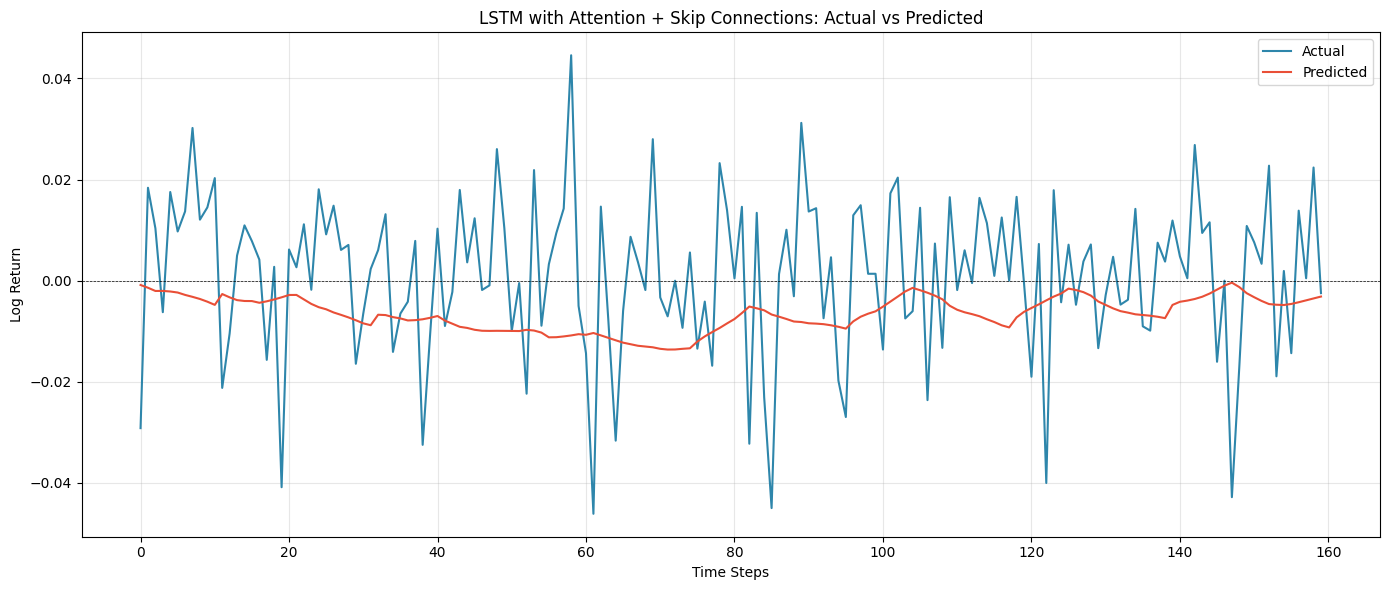

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(range(len(y_true_lstm_skip)), y_true_lstm_skip, label='Actual', color='#2E86AB', linewidth=1.5)
ax.plot(range(len(y_pred_lstm_skip)), y_pred_lstm_skip, label='Predicted', color='#E94F37', linewidth=1.5)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Log Return')
ax.set_title(f'LSTM with Attention + Skip Connections: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

                   Model      MSE     RMSE      MAE
            Baseline RNN 0.000358 0.018908 0.015957
         RNN + Attention 0.000483 0.021967 0.018907
  RNN + Attention + Skip 0.000287 0.016931 0.013676
                   BiRNN 0.000424 0.020591 0.017440
       BiRNN + Attention 0.000284 0.016856 0.013604
BiRNN + Attention + Skip 0.000287 0.016938 0.012640
                    LSTM 0.000301 0.017348 0.013072
        LSTM + Attention 0.000268 0.016367 0.013082
 LSTM + Attention + Skip 0.000310 0.017608 0.014475


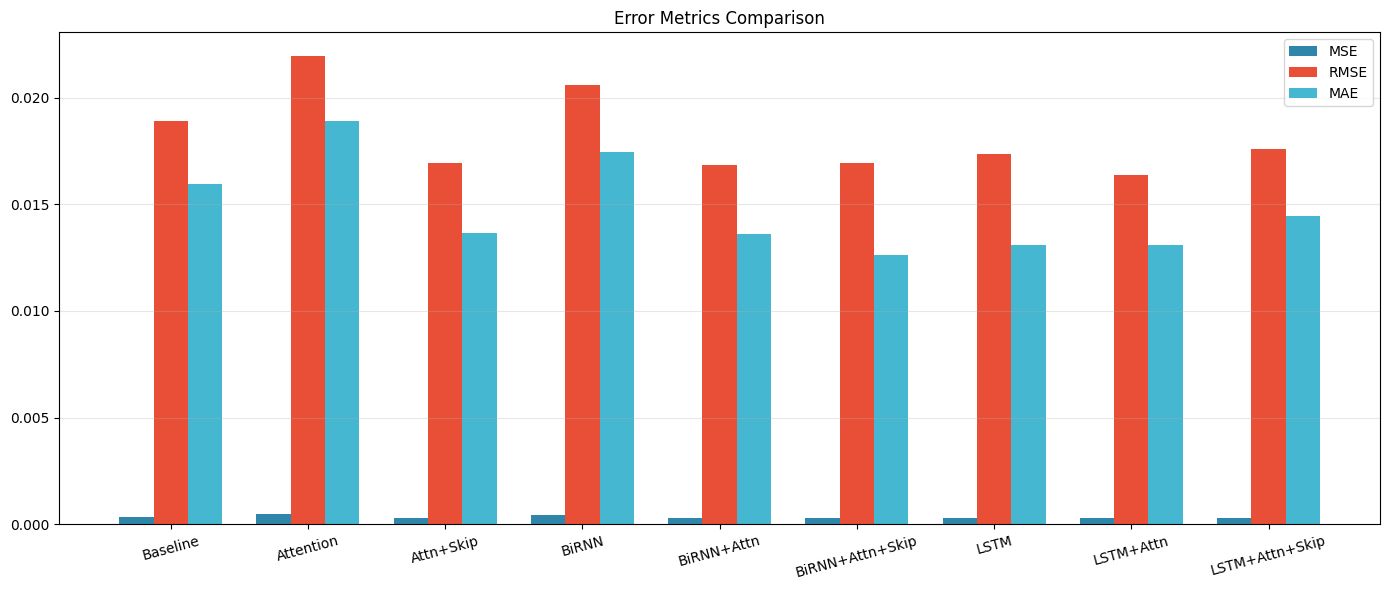

In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline RNN', 'RNN + Attention', 'RNN + Attention + Skip',
              'BiRNN', 'BiRNN + Attention', 'BiRNN + Attention + Skip',
              'LSTM', 'LSTM + Attention', 'LSTM + Attention + Skip'],
    'MSE': [mse, mse_att, mse_skip, mse_bidir, mse_bidir_att, mse_bidir_skip,
            mse_lstm, mse_lstm_att, mse_lstm_skip],
    'RMSE': [rmse, rmse_att, rmse_skip, rmse_bidir, rmse_bidir_att, rmse_bidir_skip,
             rmse_lstm, rmse_lstm_att, rmse_lstm_skip],
    'MAE': [mae, mae_att, mae_skip, mae_bidir, mae_bidir_att, mae_bidir_skip,
            mae_lstm, mae_lstm_att, mae_lstm_skip]
})

print(comparison_df.to_string(index=False))

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

x = np.arange(9)
width = 0.25

ax.bar(x - width, [mse, mse_att, mse_skip, mse_bidir, mse_bidir_att, mse_bidir_skip,
                    mse_lstm, mse_lstm_att, mse_lstm_skip], width, label='MSE', color='#2E86AB')
ax.bar(x, [rmse, rmse_att, rmse_skip, rmse_bidir, rmse_bidir_att, rmse_bidir_skip,
           rmse_lstm, rmse_lstm_att, rmse_lstm_skip], width, label='RMSE', color='#E94F37')
ax.bar(x + width, [mae, mae_att, mae_skip, mae_bidir, mae_bidir_att, mae_bidir_skip,
                    mae_lstm, mae_lstm_att, mae_lstm_skip], width, label='MAE', color='#45B7D1')
ax.set_xticks(x)
ax.set_xticklabels(['RNN', 'RNN+Attn', 'RNN+Attn+Skip', 'BiRNN', 'BiRNN+Attn', 'BiRNN+Attn+Skip',
                     'LSTM', 'LSTM+Attn', 'LSTM+Attn+Skip'], rotation=15)
ax.set_title('Error Metrics Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()